In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

In [2]:
np.random.seed(42)

In [3]:
#load train and test data from csv to DataFrame
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

In [4]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
df_train.shape

(159571, 8)

In [8]:
import seaborn as sns

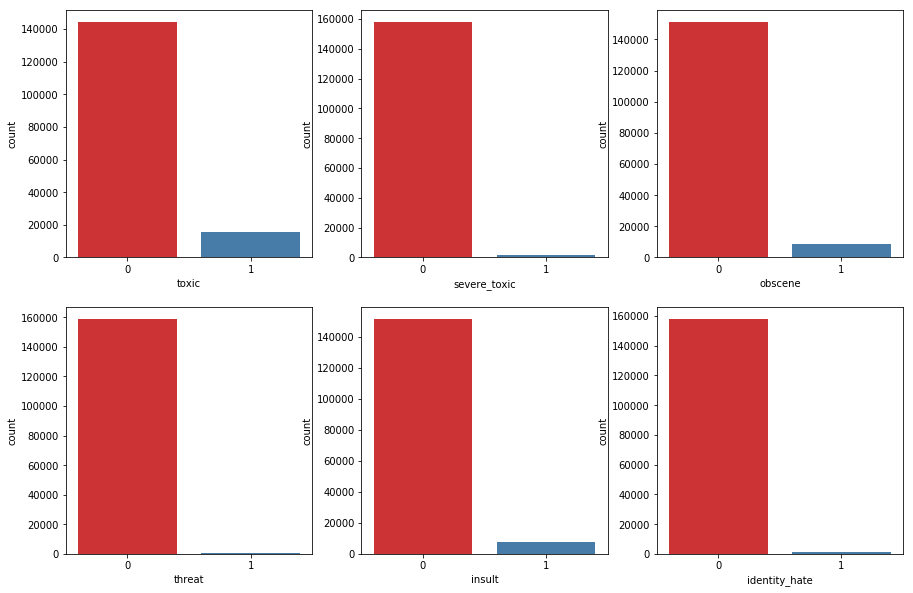

In [9]:
# visualization of training dataset
fig,ax = plt.subplots(2,3,figsize = (15,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(x= df_train['toxic'],palette="Set1",ax= ax1)
sns.countplot(x= df_train['severe_toxic'],palette="Set1",ax =ax2)
sns.countplot(x= df_train['obscene'],palette="Set1",ax =ax3)
sns.countplot(x= df_train['threat'],palette="Set1",ax =ax4)
sns.countplot(x= df_train['insult'],palette="Set1",ax =ax5)
sns.countplot(x= df_train['identity_hate'],palette="Set1",ax =ax6)

In [10]:
# have a general look at train numerical dataset
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# check if there is missing data in train comments
df_train['comment_text'].isnull().sum()

0

In [12]:
# check if there is missing data in test comments
df_test['comment_text'].isnull().sum()

0

In [13]:
# Preprocessing
train_comments = df_train['comment_text']
test_comments = df_test['comment_text']

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
153159    . \n i totally agree, this stuff is nothing bu...
153160    == Throw from out field to home plate. == \n\n...
153161    " \n\n == Okinotorishima categories == \n\n I ...
153162    " \n\n == ""One of the founding nations of the...
153163    " \n :::Stop already. Your bullshit is not wel...
Name: comment_text, Length: 312735, dtype: object

In [14]:
# tfidf model for word & char
word_vec = TfidfVectorizer(strip_accents='unicode',ngram_range=(1, 1),
                           stop_words = 'english',analyzer='word',
                           token_pattern=r'\w{1,}',max_features=20000,
                          sublinear_tf=True)

char_vec = TfidfVectorizer(strip_accents='unicode',ngram_range=(1, 5),
                           stop_words = 'english',analyzer='char',
                           max_features=40000,sublinear_tf=True)

In [34]:
# fit and transfrom for train and test data
train_word_fea = word_vec.fit_transform(train_comments)
test_word_fea = word_vec.transform(test_comments)

train_char_fea = char_vec.fit_transform(train_comments)
test_char_fea = char_vec.transform(test_comments)

In [36]:
train_comment_fea = hstack([train_word_fea, train_char_fea])
test_comment_fea = hstack([test_word_fea, test_char_fea])

In [37]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat','insult',
               'identity_hate']

In [41]:
# use onevsrest classifier and logistic regression to create model and 
# make predictions
cv_scores = []
predictions = pd.DataFrame.from_dict({'id': df_test['id']})
for class_name in class_names:
    y_train = df_train[class_name]
    clf = OneVsRestClassifier(LogisticRegression(solver='sag'))

    cv_score = np.mean(cross_val_score(clf, train_comment_fea, y_train,
                                       cv=3, scoring='roc_auc'))
    cv_scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    clf.fit(train_comment_fea, y_train)
    predictions[class_name] = clf.predict_proba(test_comment_fea)[:, 1]

print('Total CV score is {}'.format(np.mean(cv_scores)))

CV score for class toxic is 0.9792750749138243
CV score for class severe_toxic is 0.9889217903091007
CV score for class obscene is 0.9907519268784851
CV score for class threat is 0.9897949682540021
CV score for class insult is 0.9832962632821173
CV score for class identity_hate is 0.9832217682294218
Total CV score is 0.9858769653111586


In [43]:
predictions.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999887,0.246773,0.999611,0.038390,0.981072,0.342431
1,0000247867823ef7,0.006427,0.002407,0.003443,0.000497,0.004405,0.002396
2,00013b17ad220c46,0.012305,0.002412,0.008030,0.000418,0.003787,0.001377
3,00017563c3f7919a,0.002924,0.001603,0.002167,0.000768,0.002684,0.000435
4,00017695ad8997eb,0.018338,0.001324,0.004565,0.000741,0.007463,0.001183


In [42]:
predictions.to_csv('predictions.csv', index=False)